# L1 Regularization
If the value of lambda is Zero then above Loss function becomes Ordinary Least Square whereas very large value makes the coefficients (weights) zero hence it under-fits.

### Imports

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as  plt
import time
import h5py
from pathlib import Path


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Create dataloaders

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

### Inputs

In [109]:
pretrained_model = '../saved_models/Carlini/L1/l1_regularized_1e-05_model_03.pth'
use_cuda = True

### Model

In [110]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 98.54 %


## Carlini

In [111]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)

    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [46]:
carlini_l2 = dict()
constants = [0.1, 0.5, 1.0, 5, 10]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))
    
print(accuracies)
print(distances)

c: 0.1  Accuracy: 0.972  Distance: 0.271
c: 0.5  Accuracy: 0.822  Distance: 1.263
c: 1.0  Accuracy: 0.565  Distance: 1.926
c: 5  Accuracy: 0.104  Distance: 3.074
c: 10  Accuracy: 0.064  Distance: 3.421
[0.972, 0.822, 0.565, 0.104, 0.064]
[0.271, 1.263, 1.926, 3.074, 3.421]


In [48]:
carlini_regularized = dict()

In [50]:
carlini_regularized['0'] = {'accuracies': np.array([0.973     , 0.78966667, 0.532     , 0.10633333, 0.06433333]),
                         'distances': np.array([0.28866667, 1.328     , 1.99633333, 3.07433333, 3.423     ])}
    
carlini_regularized['1e-01'] = {'accuracies': np.array([0.973   ,   0.796 ,     0.518,      0.07766667 ,0.05433333]), 
                              'distances': np.array([0.292  ,    1.333 ,     2.012  ,    3.11166667, 3.39666667])}
    
carlini_regularized['1e-02'] = {'accuracies': np.array([0.97566667 ,0.77333333, 0.493  ,    0.074   ,   0.05133333]), 
                              'distances': np.array([0.29266667, 1.37566667, 2.044  ,    3.1   ,     3.39633333])}
    
carlini_regularized['1e-03'] = {'accuracies': np.array([0.97366667 ,0.76266667, 0.50333333 ,0.08166667, 0.05566667]), 
                              'distances': np.array([0.26333333 ,1.37066667 ,1.985,      3.052  ,    3.35966667])}

carlini_regularized['1e-04'] = {'accuracies': np.array([0.97366667, 0.74833333 ,0.478 ,     0.08266667, 0.05933333]), 
                              'distances': np.array([0.28166667 ,1.44966667 ,2.052     , 3.061  ,    3.36933333])}

carlini_regularized['1e-05'] = {'accuracies': np.array([0.97566667, 0.789  ,    0.521 ,     0.09033333 ,0.05766667]), 
                              'distances': np.array([0.294    ,  1.38566667 ,2.01566667 ,3.07833333 ,3.39566667])}
carlini_regularized

{'0': {'accuracies': array([0.973     , 0.78966667, 0.532     , 0.10633333, 0.06433333]),
  'distances': array([0.28866667, 1.328     , 1.99633333, 3.07433333, 3.423     ])},
 '1e-01': {'accuracies': array([0.973     , 0.796     , 0.518     , 0.07766667, 0.05433333]),
  'distances': array([0.292     , 1.333     , 2.012     , 3.11166667, 3.39666667])},
 '1e-02': {'accuracies': array([0.97566667, 0.77333333, 0.493     , 0.074     , 0.05133333]),
  'distances': array([0.29266667, 1.37566667, 2.044     , 3.1       , 3.39633333])},
 '1e-03': {'accuracies': array([0.97366667, 0.76266667, 0.50333333, 0.08166667, 0.05566667]),
  'distances': array([0.26333333, 1.37066667, 1.985     , 3.052     , 3.35966667])},
 '1e-04': {'accuracies': array([0.97366667, 0.74833333, 0.478     , 0.08266667, 0.05933333]),
  'distances': array([0.28166667, 1.44966667, 2.052     , 3.061     , 3.36933333])},
 '1e-05': {'accuracies': array([0.97566667, 0.789     , 0.521     , 0.09033333, 0.05766667]),
  'distances': 

### LInf

In [112]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.01  Accuracy: 0.98
eps: 0.1  Accuracy: 0.936
eps: 0.2  Accuracy: 0.777
eps: 0.3  Accuracy: 0.568
eps: 0.4  Accuracy: 0.376
eps: 0.5  Accuracy: 0.215
eps: 0.6  Accuracy: 0.121
[0.98, 0.936, 0.777, 0.568, 0.376, 0.215, 0.121]


In [113]:
a = np.mean([
    [0.988, 0.932, 0.761, 0.551, 0.321, 0.181, 0.086],
    [0.988, 0.934, 0.756, 0.556, 0.34, 0.172, 0.091],
    [0.98, 0.936, 0.777, 0.568, 0.376, 0.215, 0.121]

], axis=0)
print(a)

[0.98533333 0.934      0.76466667 0.55833333 0.34566667 0.18933333
 0.09933333]


In [115]:
carlini_inf_regularized = dict()
carlini_inf_regularized['0'] = [0.987, 0.92966667, 0.78033333, 0.56866667, 0.368, 0.197, 0.10833333]
carlini_inf_regularized['1e-01'] = [0.985 , 0.933 , 0.761 , 0.533 , 0.324 , 0.161 , 0.0855]
carlini_inf_regularized['1e-02'] = [0.98533333, 0.92766667 ,0.76766667, 0.53666667, 0.31933333, 0.162, 0.08 ]
carlini_inf_regularized['1e-03'] = [0.9865, 0.916 , 0.754 , 0.5225, 0.2985 ,0.149 , 0.079 ]
carlini_inf_regularized['1e-04'] = [0.98466667, 0.927   ,   0.75566667, 0.53666667, 0.33066667 ,0.17666667, 0.098     ]
carlini_inf_regularized['1e-05'] = [0.98533333, 0.934     , 0.76466667, 0.55833333, 0.34566667, 0.18933333, 0.09933333]

## Results

### L2

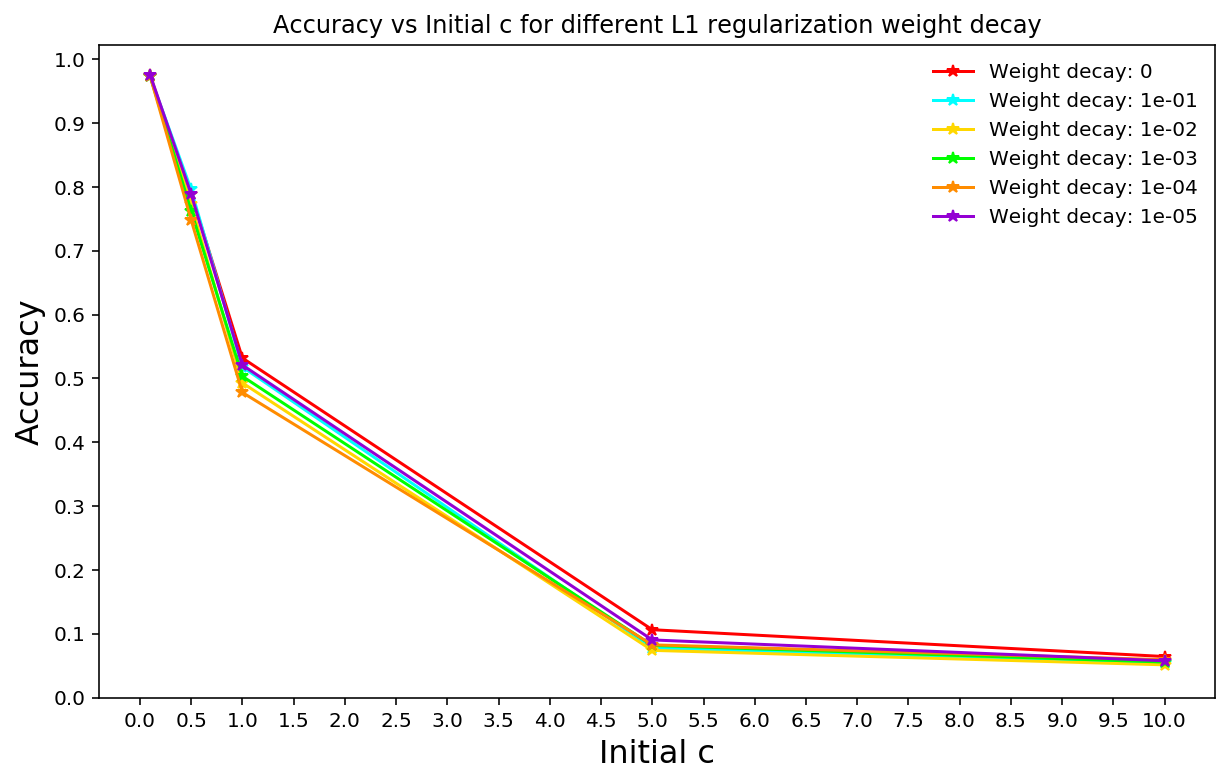

In [55]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime', 'darkorange', 'darkviolet']

for idx, (decay, results) in enumerate(carlini_regularized.items()):
    plt.plot(constants, results['accuracies'], "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("Accuracy vs Initial c for different L1 regularization weight decay")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

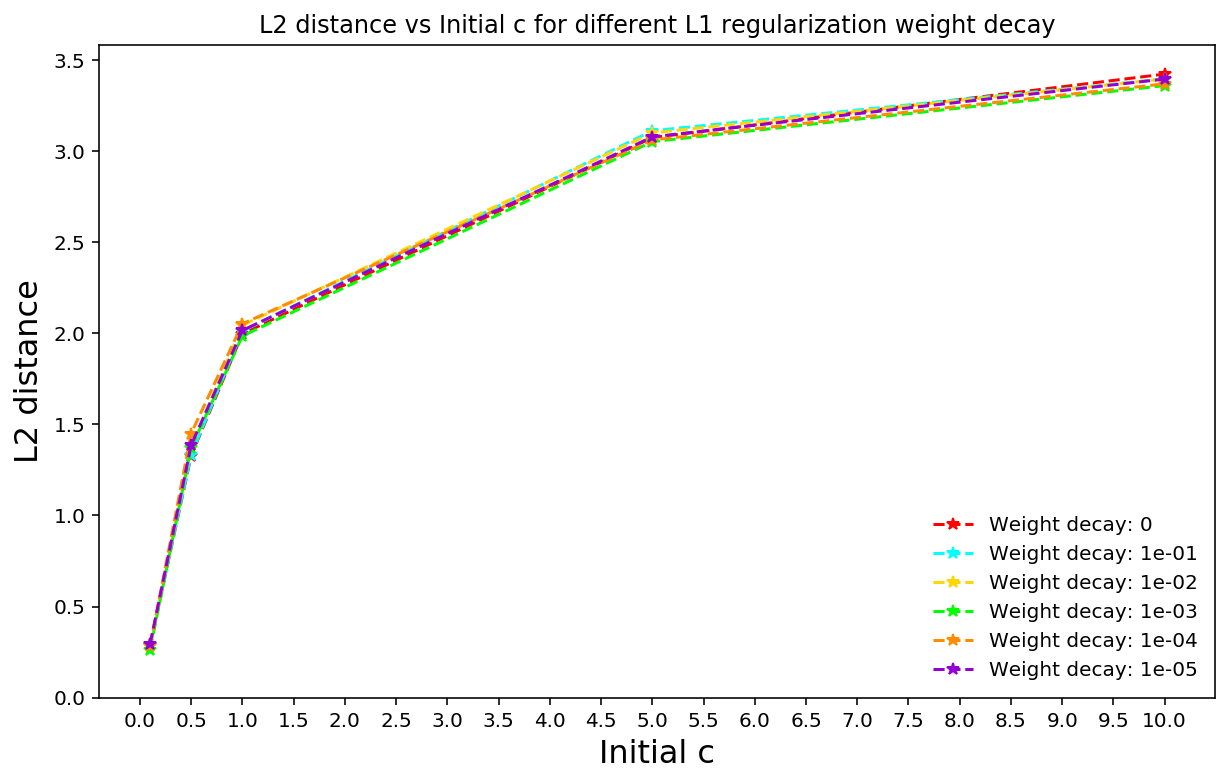

In [54]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime', 'darkorange', 'darkviolet']

for idx, (decay, results) in enumerate(carlini_regularized.items()):
    plt.plot(constants, results['distances'], "*--", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("L2 distance vs Initial c for different L1 regularization weight decay")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

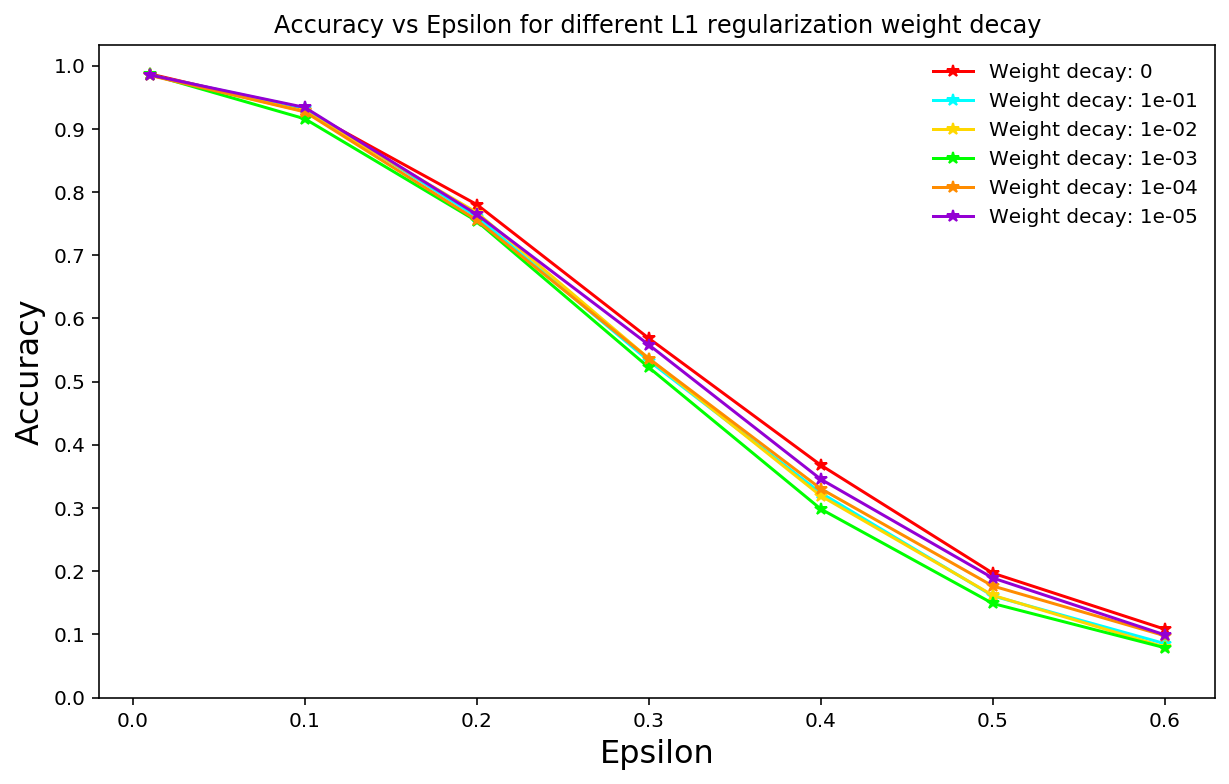

In [117]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime', 'darkorange', 'darkviolet']

for idx, (decay, results) in enumerate(carlini_inf_regularized.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Accuracy vs Epsilon for different L1 regularization weight decay")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()